In [1]:
import pandas as pd                                                                        
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [2]:
from keras.models import load_model

e:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def summary_tables(train_pred,train_true,test_pred,test_true,threshold = 0.5):
    train_pred_class = (train_pred <threshold).astype(int)
    test_pred_class  = (test_pred <threshold).astype(int)   
    #train and validation
    #print(test_pred_class)
    train_cm = confusion_matrix(train_true,train_pred_class ).ravel()
    test_cm = confusion_matrix(test_true,test_pred_class ).ravel()
    train_test_table = pd.DataFrame([train_cm,test_cm],columns = ["True Negative","False Positve",'False Negative','True Positive'],
                index = ['Training Data','Validation'])
    #confusion matrix of validation
    c_m_test = confusion_matrix(test_true,test_pred_class )
    c_m_test = pd.DataFrame(c_m_test,columns = ["Bad(Predict Negative)","Good(Predict Positve)"],
                            index = ["Bad(Observed)","Good(Observed)"])
    c_m_test.loc ['Pecentage Negative'] = c_m_test.loc["Bad(Observed)"]/c_m_test.loc["Bad(Observed)"].sum()
    c_m_test.loc ['Pecentage Positive'] = c_m_test.loc["Good(Observed)"]/c_m_test.loc["Good(Observed)"].sum()

    c_m_test ['Row Total'] = c_m_test.sum(axis = 1)
    c_m_test.loc ['Column Total'] = c_m_test.sum(axis = 0)
    c_m_test = c_m_test.reindex(index =[ "Bad(Observed)",'Pecentage Negative',\
                     "Good(Observed)",'Pecentage Positive',"Column Total"])
    c_m_test.round(2)
    return train_test_table ,c_m_test.round(2)
def roc_plot(y_true,y_pred_prob,model_name):
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob,pos_label = 1)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC for {}'.format(model_name))
    plt.legend(loc="lower right")

In [4]:
data = pd.read_excel("E:/download/German_creditscoring.xls")
facotrize_dict = {}
for col in data.columns:
    if data[col].dtypes == object :
        data[col] = data[col].astype('category')
        col_dict = dict( enumerate(data[col].cat.categories ) )
        facotrize_dict[col] = col_dict

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [38]:
data.head()

,Creditability,Balance of current account,Duration in months,Payment of previous credits,Purpose of credit,Amount of credit in DM,Value of savings or stocks,Has been employed by current employer for,Installment in % of available income,Marital Status/Sex,...,Most valuable available assets,Age in years,Further running credits,Type of apartment,Number of previous credits at this bank,Occupation,Number of persons entitled to maintainance,Telephone,Foreign worker,NewVar
0,bad,no running account,36,no problems with current credits at this bank,retraining,2145,no savings,between 4 and 7 years,between 25 and 35,male:single,...,savings contract with a building society/Life ...,24,no further running credits,rented,2 or 3,skilled worker/skilled employee/minor civil se...,3 and more,yes,yes,2.960619
1,good,no balance,48,hesistant payment of previous credits,retraining,12204,greater than 1000 DM,between 1 and 4 years,between 25 and 35,male:single,...,savings contract with a building society/Life ...,48,at other banks,rented,one,executive/self-employed/higher civil servant,3 and more,yes,yes,2.879810
2,bad,>=200 DM,36,no previous credits or paid back,used car,10974,no savings,unemployed,less than 20,female:divorced/living apart/married,...,savings contract with a building society/Life ...,26,no further running credits,rented,2 or 3,executive/self-employed/higher civil servant,3 and more,yes,yes,2.592734
3,good,no running account,24,paid back previous credits at this bank,new car,6419,no savings,greater than 7 years,between 25 and 35,female:divorced/living apart/married,...,ownership of house or land,44,no further running credits,owner,2 or 3,executive/self-employed/higher civil servant,0 to 2,yes,yes,2.576883
4,good,>=200 DM,24,no previous credits or paid back,retraining,1258,no savings,between 4 and 7 years,less than 20,male:single,...,no assets,25,no further running credits,rented,one,skilled worker/skilled employee/minor civil se...,3 and more,yes,yes,2.527170


In [5]:
data.columns

Index(['Creditability', 'Balance of current account', 'Duration in months',
       'Payment of previous credits', 'Purpose of credit',
       'Amount of credit in DM', 'Value of savings or stocks',
       'Has been employed by current employer for',
       'Installment in % of available income', 'Marital Status/Sex',
       'Further debtors/Guarantors', 'Living in current household for',
       'Most valuable available assets', 'Age in years',
       'Further running credits', 'Type of apartment',
       'Number of previous credits at this bank', 'Occupation',
       'Number of persons entitled to maintainance', 'Telephone',
       'Foreign worker', 'NewVar'],
      dtype='object')

In [6]:
facotrize_dict.keys()

dict_keys(['Creditability', 'Balance of current account', 'Payment of previous credits', 'Purpose of credit', 'Value of savings or stocks', 'Has been employed by current employer for', 'Installment in % of available income', 'Marital Status/Sex', 'Further debtors/Guarantors', 'Living in current household for', 'Most valuable available assets', 'Further running credits', 'Type of apartment', 'Number of previous credits at this bank', 'Occupation', 'Number of persons entitled to maintainance', 'Telephone', 'Foreign worker'])

# Explore the Dependent variable

In [26]:
y_stat = data["Creditability"].value_counts().sort_index()

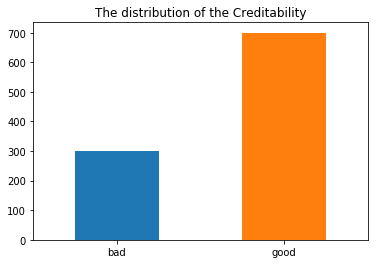

In [27]:
y_stat.plot("bar",rot = 0,title = "The distribution of the Creditability")

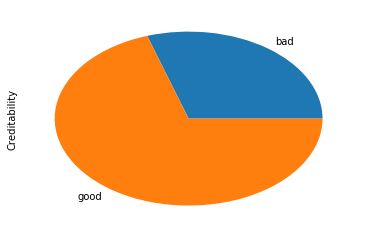

In [32]:
(y_stat/y_stat.sum()).plot("pie")

This is an imbalanced dataset. The "good" label is 70% of total dataset. Which means that, if the model only predict "good", it will got 70% accuracy, the case we don't want

There are two methods to solve this problem:
 - sampling
     - oversampling: Can be use but my lead to overfitting problems
     - undersampling: This method is not suitable for this case because we only has 1000 observations
 - Change the class weights: In keras, you can simply set class_weight = {0:0.7,1:0.3}, the opposite of ratio.

In [8]:
y = data['Creditability'].cat.codes
X = data.drop('Creditability',axis = 1)
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(1000, 21) (1000,)


In [9]:
cat_columns =[]
for col in X_train.columns:
    if X_train[col].dtype != np.int64 and X_train[col].dtype != np.float64 and X_train[col].dtype == "category":
        cat_columns.append(col)
cat_columns
NN_X_train = pd.get_dummies(X_train,columns = cat_columns)
NN_X_test = pd.get_dummies(X_test,columns = cat_columns)

input_shape = (NN_X_train.shape[1],)
print(input_shape)

(72,)


# Neural Network

Train on 700 samples, validate on 300 samples
Epoch 1/1000
700/700 [==============================] - 0s 372us/step - loss: 2.9223 - acc: 0.4043 - val_loss: 10.9342 - val_acc: 0.2967

Epoch 00001: val_loss improved from inf to 10.93422, saving model to 686_case3_model.hdf5
Epoch 2/1000
700/700 [==============================] - 0s 64us/step - loss: 3.1387 - acc: 0.3186 - val_loss: 10.3206 - val_acc: 0.3067

Epoch 00002: val_loss improved from 10.93422 to 10.32058, saving model to 686_case3_model.hdf5
Epoch 3/1000
700/700 [==============================] - 0s 64us/step - loss: 2.8754 - acc: 0.4643 - val_loss: 10.2458 - val_acc: 0.3067

Epoch 00003: val_loss improved from 10.32058 to 10.24585, saving model to 686_case3_model.hdf5
Epoch 4/1000
700/700 [==============================] - 0s 70us/step - loss: 2.5512 - acc: 0.4629 - val_loss: 10.3850 - val_acc: 0.3067

Epoch 00004: val_loss did not improve from 10.24585
Epoch 5/1000
700/700 [==============================] - 0s 70us/step - lo

700/700 [==============================] - 0s 71us/step - loss: 1.9819 - acc: 0.4743 - val_loss: 3.2568 - val_acc: 0.7033

Epoch 00042: val_loss did not improve from 1.19509
Epoch 43/1000
700/700 [==============================] - 0s 67us/step - loss: 1.7262 - acc: 0.5486 - val_loss: 1.2874 - val_acc: 0.7367

Epoch 00043: val_loss did not improve from 1.19509
Epoch 44/1000
700/700 [==============================] - 0s 64us/step - loss: 1.7837 - acc: 0.5957 - val_loss: 8.6375 - val_acc: 0.3467

Epoch 00044: val_loss did not improve from 1.19509
Epoch 45/1000
700/700 [==============================] - 0s 68us/step - loss: 1.6317 - acc: 0.5271 - val_loss: 4.1714 - val_acc: 0.7033

Epoch 00045: val_loss did not improve from 1.19509
Epoch 46/1000
700/700 [==============================] - 0s 67us/step - loss: 1.8635 - acc: 0.5486 - val_loss: 7.3683 - val_acc: 0.3967

Epoch 00046: val_loss did not improve from 1.19509
Epoch 47/1000
700/700 [==============================] - 0s 66us/step - lo

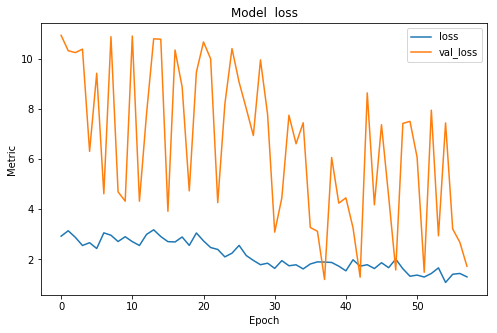

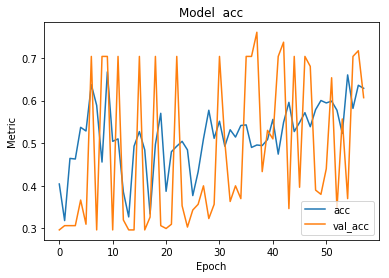

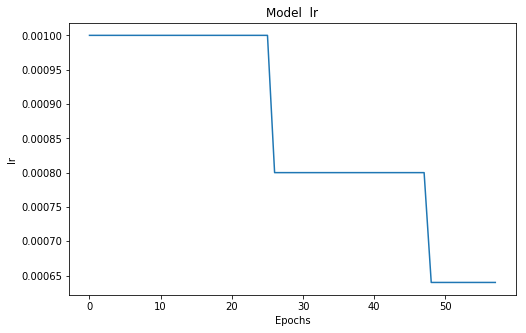

Best training accuracy 0.76


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

l2_rate = 0.001
dropout_rate = 0.6
middle_layers = 5
epochs = 1000
batch_size = 32
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=10, min_lr=0.00001)
check_point = ModelCheckpoint('686_case3_model.hdf5',monitor='val_loss',verbose=True, save_best_only=True)
NN_early_stop = EarlyStopping(monitor='val_loss',patience=20,verbose=True)

model = Sequential([
    Dense(32, input_shape=input_shape,activation = 'relu' ),
   # Dense(32, input_shape=input_shape,kernel_initializer =kernel_initializer,activation = 'relu' ),
    Dense(1,activation = 'sigmoid'  ),
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
                        NN_X_train, y_train,
                        epochs=epochs,
                        batch_size= batch_size,
                        validation_data=( NN_X_test, y_test),
                        verbose = 1,
                        initial_epoch = 0,
                        class_weight = {0:0.7,1:0.3},
                        callbacks=[
                        NN_early_stop,
                       check_point, 
                        reduce_lr])

plt.figure(figsize =  (8,5))
#plt.plot(history.history['quadratic_weighted_kappa'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model  loss')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model  acc')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()

plt.figure(figsize =  (8,5))
#plt.plot(history.history['quadratic_weighted_kappa'])
plt.plot(history.history['lr'])
plt.title('Model  lr')
plt.ylabel('lr')
plt.xlabel('Epochs')
plt.show()
print('Best training accuracy',max(history.history['val_acc']))

In [35]:
NN_base_model = load_model('686_case3_model.hdf5')
NN_train_pred = NN_base_model.predict(NN_X_train).reshape(len(NN_X_train),)
NN_test_pred = NN_base_model.predict(NN_X_test).reshape(len(NN_X_test),)

,True Negative,False Positve,False Negative,True Positive
Training Data,138,73,437,52
Validation,56,33,195,16


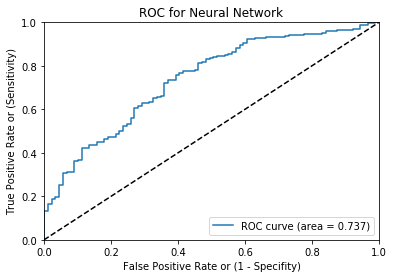

In [37]:
roc_plot(y_test, NN_test_pred,'Neural Network')
a,b = summary_tables(NN_train_pred,y_train,NN_test_pred,y_test,threshold = 0.5)
a

In [39]:
b

,Bad(Predict Negative),Good(Predict Positve),Row Total
Bad(Observed),56.00,33.00,89.0
Pecentage Negative,0.63,0.37,1.0
Good(Observed),195.00,16.00,211.0
Pecentage Positive,0.92,0.08,1.0
Column Total,252.55,49.45,302.0


# LightGBM

In [14]:
import lightgbm as lgb
param = {'num_leaves':200, 
         'num_trees':200, 
         'metric': ['auc'],
        'max_bin' : 500
        }
# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 10000
n_splits = 5

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test)
watchlist = [d_train, d_valid]

GBM_model = lgb.train(param,
                  train_set=d_train,
                  num_boost_round=num_rounds,
                  valid_sets=watchlist,
                  verbose_eval=verbose_eval,
                  early_stopping_rounds=early_stop)

e:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
e:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 1	valid_1's auc: 0.744768
[200]	training's auc: 1	valid_1's auc: 0.736141
Did not meet early stopping. Best iteration is:
[68]	training's auc: 1	valid_1's auc: 0.751744


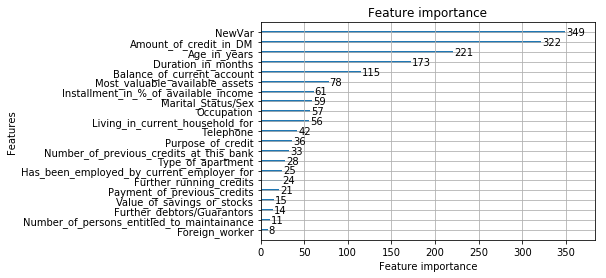

In [15]:
ax = lgb.plot_importance(GBM_model)
plt.show()

In [16]:
gbm_train_pred = GBM_model.predict(X_train, num_iteration=GBM_model.best_iteration)
gbm_test_pred = GBM_model.predict(X_test, num_iteration=GBM_model.best_iteration)

In [17]:
"""
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_train, gbm_train_pred,pos_label = 1)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
"""

'\n# Compute fpr, tpr, thresholds and roc auc\nfpr, tpr, thresholds = roc_curve(y_train, gbm_train_pred,pos_label = 1)\nroc_auc = auc(fpr, tpr)\n# Plot ROC curve\nplt.plot(fpr, tpr, label=\'ROC curve (area = %0.3f)\' % roc_auc)\nplt.plot([0, 1], [0, 1], \'k--\')  # random predictions curve\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.0])\nplt.xlabel(\'False Positive Rate or (1 - Specifity)\')\nplt.ylabel(\'True Positive Rate or (Sensitivity)\')\nplt.title(\'Receiver Operating Characteristic\')\nplt.legend(loc="lower right")\n'

,True Negative,False Positve,False Negative,True Positive
Training Data,4,207,489,0
Validation,53,36,183,28


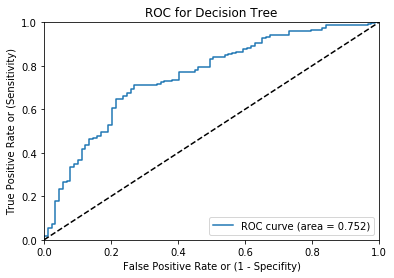

In [18]:
roc_plot(y_test, gbm_test_pred,'Decision Tree')
a,b = summary_tables(gbm_train_pred,y_train,gbm_test_pred,y_test,threshold = 0.5)
a

In [19]:
b

,Bad(Predict Negative),Good(Predict Positve),Row Total
Bad(Observed),53.00,36.00,89.0
Pecentage Negative,0.60,0.40,1.0
Good(Observed),183.00,28.00,211.0
Pecentage Positive,0.87,0.13,1.0
Column Total,237.46,64.54,302.0


# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()


In [23]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)

In [24]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                      multi_class='ovr').fit(NN_X_train, y_train)
logit_train_pred = clf.predict_proba(NN_X_train)[:,1]
logit_test_pred = clf.predict_proba(NN_X_test)[:,1]

,True Negative,False Positve,False Negative,True Positive
Training Data,99,112,432,57
Validation,51,38,179,32


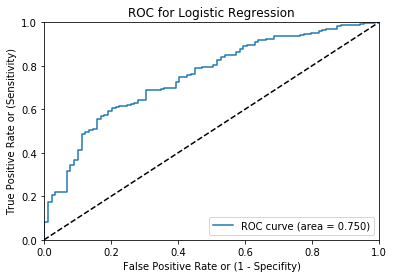

In [25]:
roc_plot(y_test, logit_test_pred,'Logistic Regression')
a,b = summary_tables(logit_train_pred,y_train,logit_test_pred,y_test,threshold = 0.5)
a

In [26]:
b

,Bad(Predict Negative),Good(Predict Positve),Row Total
Bad(Observed),51.00,38.00,89.0
Pecentage Negative,0.57,0.43,1.0
Good(Observed),179.00,32.00,211.0
Pecentage Positive,0.85,0.15,1.0
Column Total,231.42,70.58,302.0
